# [Taylor law](https://en.wikipedia.org/wiki/Taylor%27s_law) 

In [1]:
import numpy as np
from scipy import stats
import os 
import pandas as pd
from plotnine import *

## Observations: Protein length distribution in different species

### Retrieve the statistical description and tax_id of species

##### Statistical description data file

In [2]:
# system
system = list(os.uname())[0]
if system == 'Linux':
    base_dir = "/media/emuro/Wes/"
elif system == 'Darwin':
    base_dir = "/Volumes/Wes/"
    
# statistics on length distribution for different species     
stat_file = base_dir + "results/geneLength/outputInputFiles/" + "analysis/some_statistics/stat_description/" 
stat_file += "proteins/stat_description.protein.uniprot_reference_proteome.tsv"
print(stat_file)

# retrieve data
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["superregnum", "species", "proteome_id", "tax_id", "uniprot_fasta_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

/Volumes/Wes/results/geneLength/outputInputFiles/analysis/some_statistics/stat_description/proteins/stat_description.protein.uniprot_reference_proteome.tsv


,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
0,bacteria,Kurthia sp. 3B1D,UP000288623,1562256,/ftp.uniprot.org/pub/databases/uniprot/current...,3621.0,285.936205,36171.895653,2.372531,0.075378
1,viruses,Prochlorococcus phage P-GSP1,UP000204021,382262,/ftp.uniprot.org/pub/databases/uniprot/current...,49.0,238.285714,73651.083333,2.180820,0.155233


(19854, 10)


##### Filter some columns and species

In [3]:
print(stat_df.shape)
print("\nsuperregnum:\n", stat_df["superregnum"].value_counts(), sep="") # superregnum is from Uniprot

cond = stat_df["superregnum"].isin(["bacteria", "archaea", "eukaryota"]) # avoid: empty or viruses
stat_df = stat_df[cond]

# filter viruses
stat_df = stat_df[stat_df["superregnum"] != "viruses"]

# No hace falta eliminar Mus caroli (eliminado en la taylor de genes), porque no está en los proteomas referencia

if 1:
    #display(stat_df.head(2))
    print(stat_df.shape)
    print("\nsuperregnum:\n", stat_df["superregnum"].value_counts(), sep="")

(19854, 10)

superregnum:
viruses      9939
bacteria     7997
eukaryota    1588
archaea       330
Name: superregnum, dtype: int64
(9915, 10)

superregnum:
bacteria     7997
eukaryota    1588
archaea       330
Name: superregnum, dtype: int64


---

## Observed Taylor law: Variance vs Length (proteins)
$\sigma^{2}$ is the variance  
$\sigma^{2} = a . \mu^{\beta}$  
Because: 
- $\log(\sigma^{2}) = \log(a) + \beta log(\mu) $

### Plot it!

In [4]:
# FUNCTIONS
###########
def plot_taylor (df2plot, col_x, col_y, x_lab, y_lab, title, bool_show_regression): 

    # Calculate best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df2plot[col_x]),np.log10(df2plot[col_y]))
    # Format the regression text
    print('v = {:4.4} * m^{:4.4};   R^2= {:2.4f}'.format(10**intercept, slope, r_value**2))
    if bool_show_regression:
        txt = '$\sigma^{2} = ' + '{:4.4} '.format(10**intercept)  + '\t \mu^{' + '{:4.4}'.format(slope) + '}' + ';\tR^{2} = ' + '{:2.4f}$'.format(r_value**2)
    else:
        txt = ''
        
    # limits and tick-breaks
    if 1: # prots (6513 merge). Manual set up
        x_limits = [70, 2300]
        y_limits = [500, 2700000]
        x_text_factor = 0.085
        y_text_factor = 0.95
    else: # automatic
        print( min(df2plot[col_x].to_list()), max(df2plot[col_x].to_list()) )
        print( min(df2plot[col_y].to_list()), max(df2plot[col_y].to_list()) )
        x_limits=[min(df2plot[col_x].to_list())/1.3, 1.3*max(df2plot[col_x].to_list())]
        y_limits=[min(df2plot[col_y].to_list())/1.3, 1.3*max(df2plot[col_y].to_list())]
        x_text_factor = 0.085
        y_text_factor = 0.95
        
    p = (   
        ggplot(df2plot, aes(col_x, col_y, color=legends_by)) + geom_point(size=0.1)
        + geom_smooth(method="lm", color="green", size=0.25, span=.8)
        + labs(title=title, x=x_lab, y=y_lab) 
        + scale_color_manual(values=['#D83B01', '#002050', '#A80000', '#FFA500', '#107C10','#EF008C', '#0078D7', '#B4009E']) # + scale_color_brewer() '#5C2D91'
        + labs(color='Clade') # legend title
        + scale_x_log10(breaks=[10 ** power for power in range(2, 4)], limits=x_limits) #, labels=scientific_format(digits=2)
        + scale_y_log10(breaks = [10**power for power in range(3, 7)], limits=y_limits)
    ) + theme(legend_position=(0.8,0.3), legend_key_size=5, legend_background=element_rect(fill='grey', alpha=0.01)) + annotate('text', x=x_text_factor*max(df2plot[col_x].to_list()), y=y_text_factor*max(df2plot[col_y].to_list()), label=txt,size=9,color="black")
    print(p)

(9915, 3)
v = 0.0168 * m^2.605;   R^2= 0.7336


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_smooth : Removed 12 rows containing missing values.


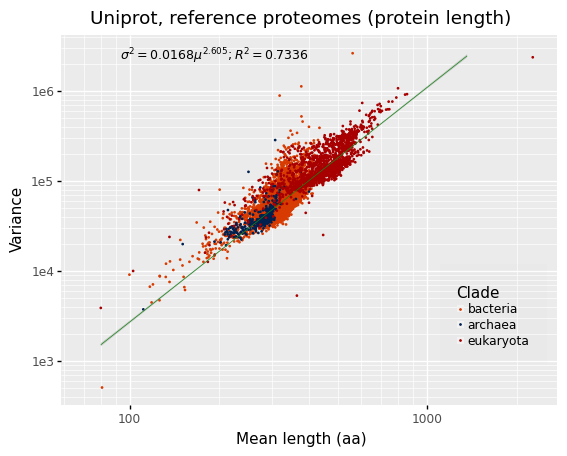

In [5]:
df2plot = stat_df.copy()
df2plot.rename(columns = {"mean" : 'prots_mean', "var" : 'prots_var'}, inplace = True)
#display(df2plot)

col_x = "prots_mean"
col_y = "prots_var"
legends_by = "superregnum"

title = "Uniprot, reference proteomes (protein length)"
x_lab = "Mean length (aa)"
y_lab = "Variance"
bool_show_regression = True

df2plot = df2plot[[legends_by, col_x, col_y]]
print(df2plot.shape)
if 0:
    df2plot.to_csv("~/tmp/goingOn/taylor_Uniprot_prot_df2plot.tsv", sep="\t", index=False) # check and erase this file


# Sort division_8 in order to plot the clades in an order (everything can be displayed)
if 0:
    print(df2plot.division_8.unique())
df2plot[legends_by] = pd.Categorical(df2plot[legends_by], 
                                categories=['bacteria', 'archaea', 'eukaryota'],
                                ordered=True)
df2plot.sort_values(legends_by, inplace=True)

plot_taylor(df2plot, col_x, col_y, x_lab, y_lab, title, bool_show_regression)
# geom_smooth error... do not concern!

---

### Plotting clade by clade:

In [7]:
if 0:
    aux_df = df2plot.copy()
    aux_df.rename(columns = {"mean" : 'prots_mean', "var" : 'prots_var'}, inplace = True)
    legends_by = "superregnum"
    print(aux_df[legends_by].unique().tolist())
    print("\nsuperregnum:\n", aux_df[legends_by].value_counts(), sep="")
    for clade in aux_df[legends_by].unique().tolist(): # for each division
        df2plot = aux_df[aux_df[legends_by]==clade] 
        print(clade)
        plot_taylor(df2plot, col_x, col_y, x_lab, y_lab, title, False) # False ->bool_show_regression = False
        # Note: it give a geom_text error...do not worry